In [1]:
import scanpy as sc
import numpy as np
import sctm
import squidpy as sq

%load_ext autoreload
%autoreload 2

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.datasets.visium_sge('V1_Breast_Cancer_Block_A_Section_1')
adata.var_names_make_unique()

100%|██████████| 9.50M/9.50M [00:01<00:00, 8.65MB/s]
100%|██████████| 26.9M/26.9M [00:02<00:00, 11.9MB/s]
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Here we do the usual preprocessing in singe cell
- remove low counts
- remove low expressed genes (We use sctm functio which just cuts off by percentage instead of exact number)
- find variable features (Personally, I found that a higher number of variable genes work better)

In [3]:
sc.pp.filter_cells(adata, min_genes=50)
sctm.pp.filter_genes(adata, 0.03,  expression_cutoff_99q = 1)
sc.pp.highly_variable_genes(adata, n_top_genes=6000, flavor="seurat_v3")

We build the graph in using squidpy's default function (Default option is the ring around each spot)

In [4]:
sq.gr.spatial_neighbors(adata)

In [5]:
n_topics = 15

In [6]:
# Only hvgs and fit a total of 20 topics
model = sctm.stamp.STAMP(
    adata[:, adata.var.highly_variable],
    n_topics = n_topics,
)

# uses gpu by default to use cpu use device="cpu"
model.train()

Computing background frequencies


/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/torch_geometric/utils/sparse.py:216: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return adj.to_sparse_csc()


tensor(22620624.)
Layer (type:depth-idx)                   Param #
OptimizedModule                          --
├─spatialLDAModel: 1-1                   --
│    └─MLPEncoderMVN: 2-1                --
│    │    └─Dropout: 3-1                 --
│    │    └─BatchNorm1d: 3-2             24,000
│    │    └─BatchNorm1d: 3-3             100
│    │    └─BatchNorm1d: 3-4             --
│    │    └─BatchNorm1d: 3-5             --
│    │    └─Linear: 3-6                  765
│    │    └─Linear: 3-7                  765
│    │    └─Linear: 3-8                  5,355
│    │    └─Linear: 3-9                  600,050
Total params: 631,035
Trainable params: 631,035
Non-trainable params: 0


Loss:6210.256:  21%|██        | 414/2000 [02:35<09:54,  2.67it/s]

Early Stopping


In [7]:
# Get topic prop which is the latent representation and beta which are the gene modules
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
# Add it into adata to visualize
for i in topic_prop.columns:
    adata.obs[i] = topic_prop[i]

... storing 'feature_types' as categorical
... storing 'genome' as categorical


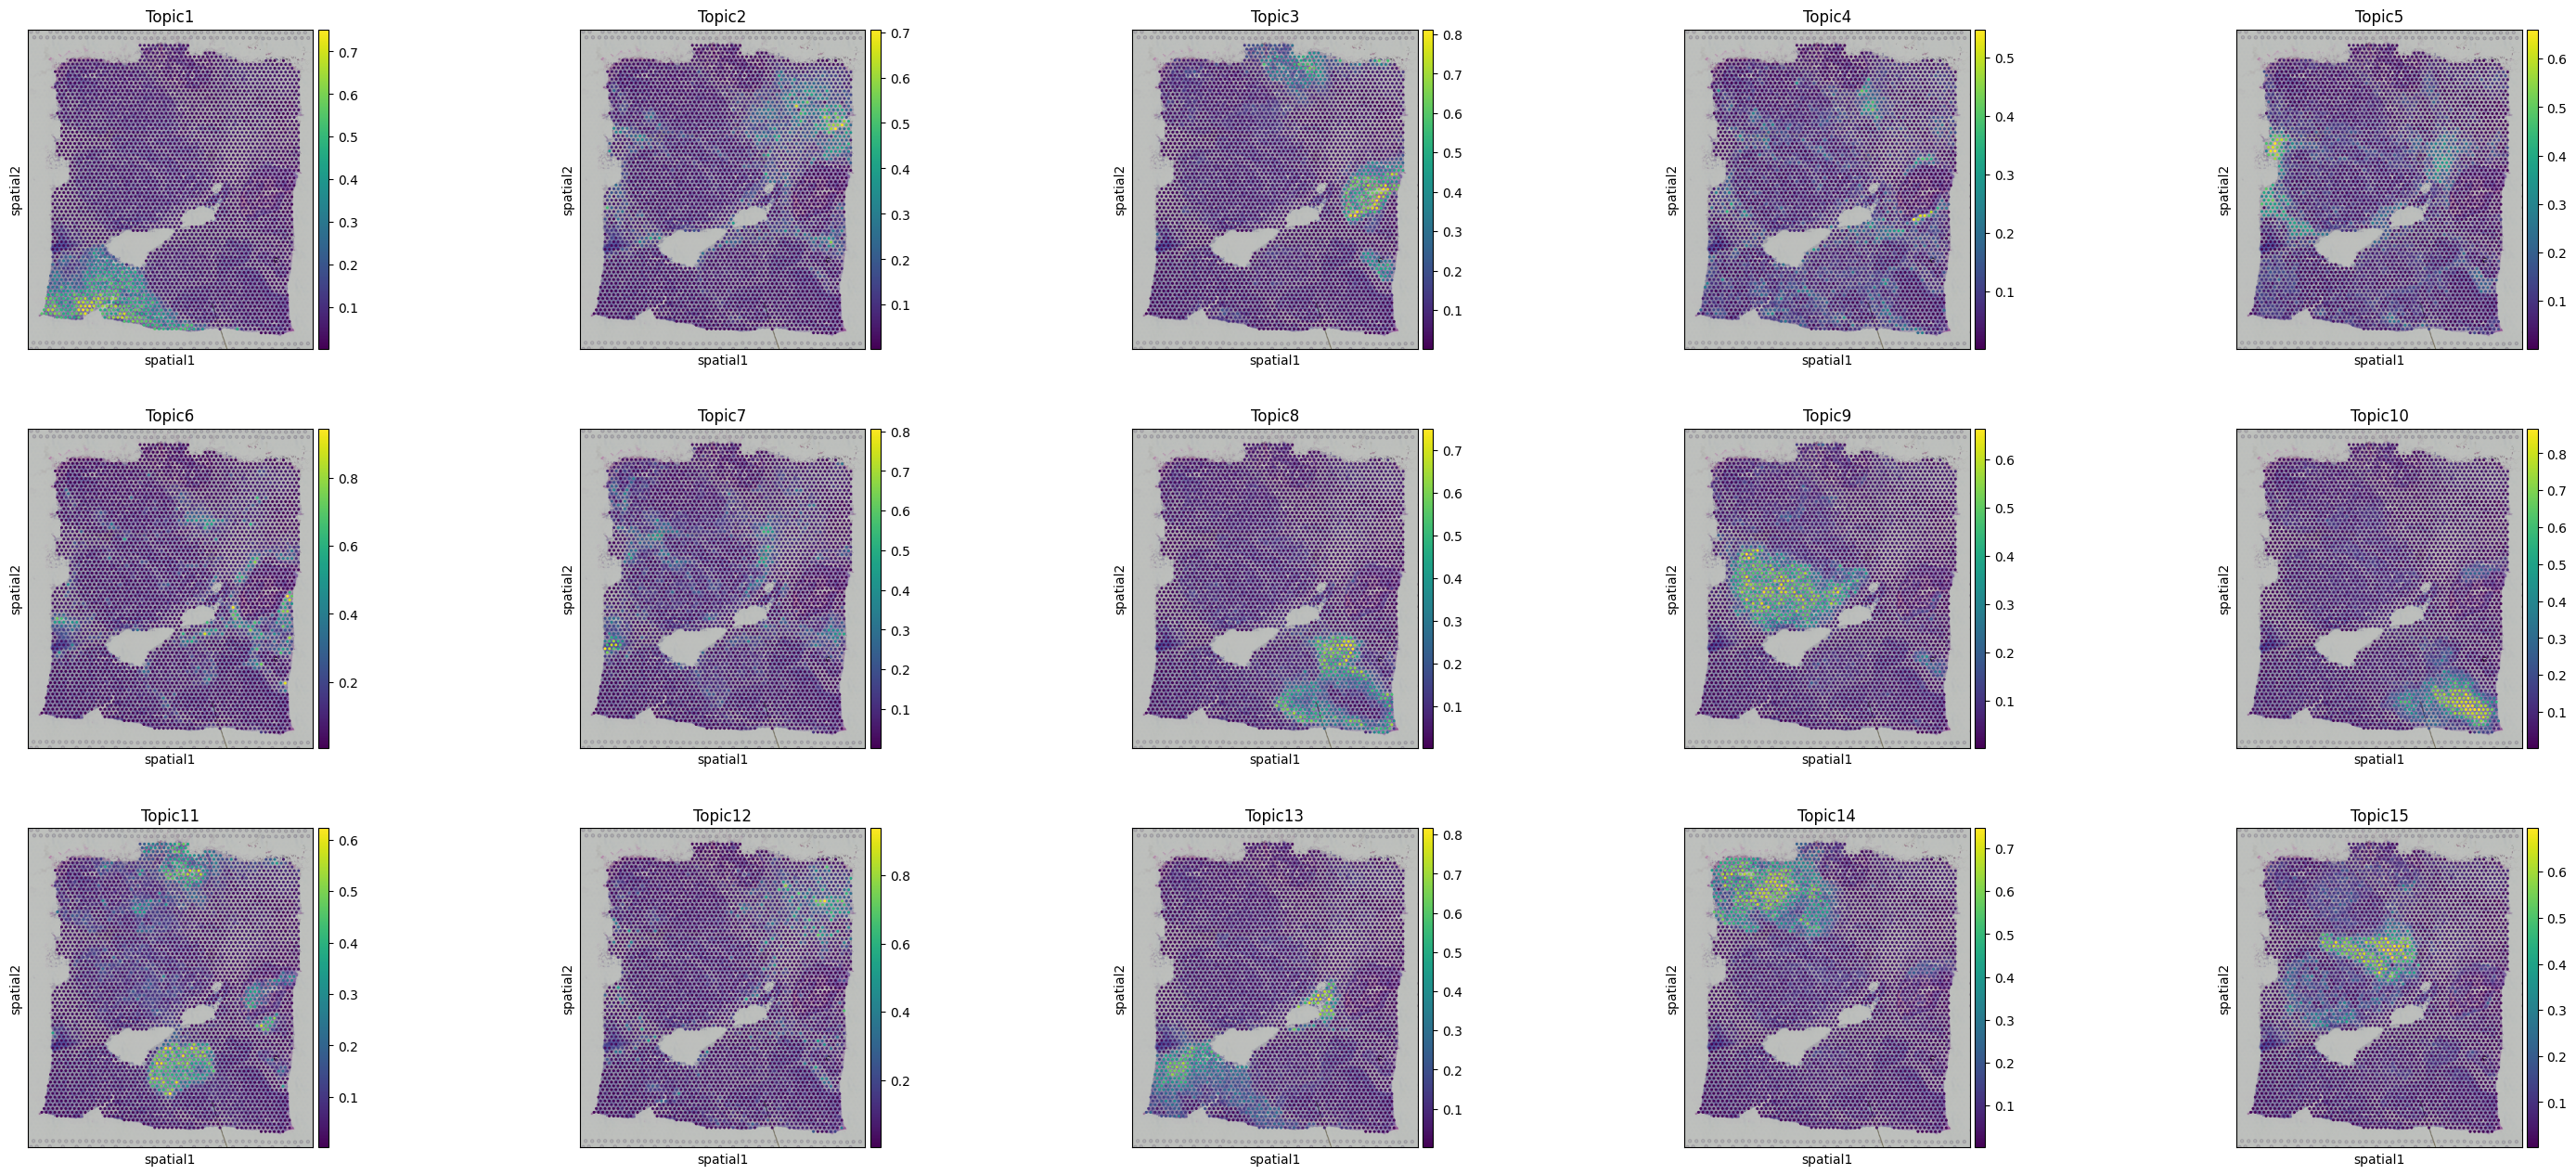

In [8]:
sc.pl.spatial(adata, color = topic_prop.columns, ncols = 5)

In [9]:
top_genes = []
for i in topic_prop.columns:
    top_genes += beta.nlargest(1, i).index.tolist()

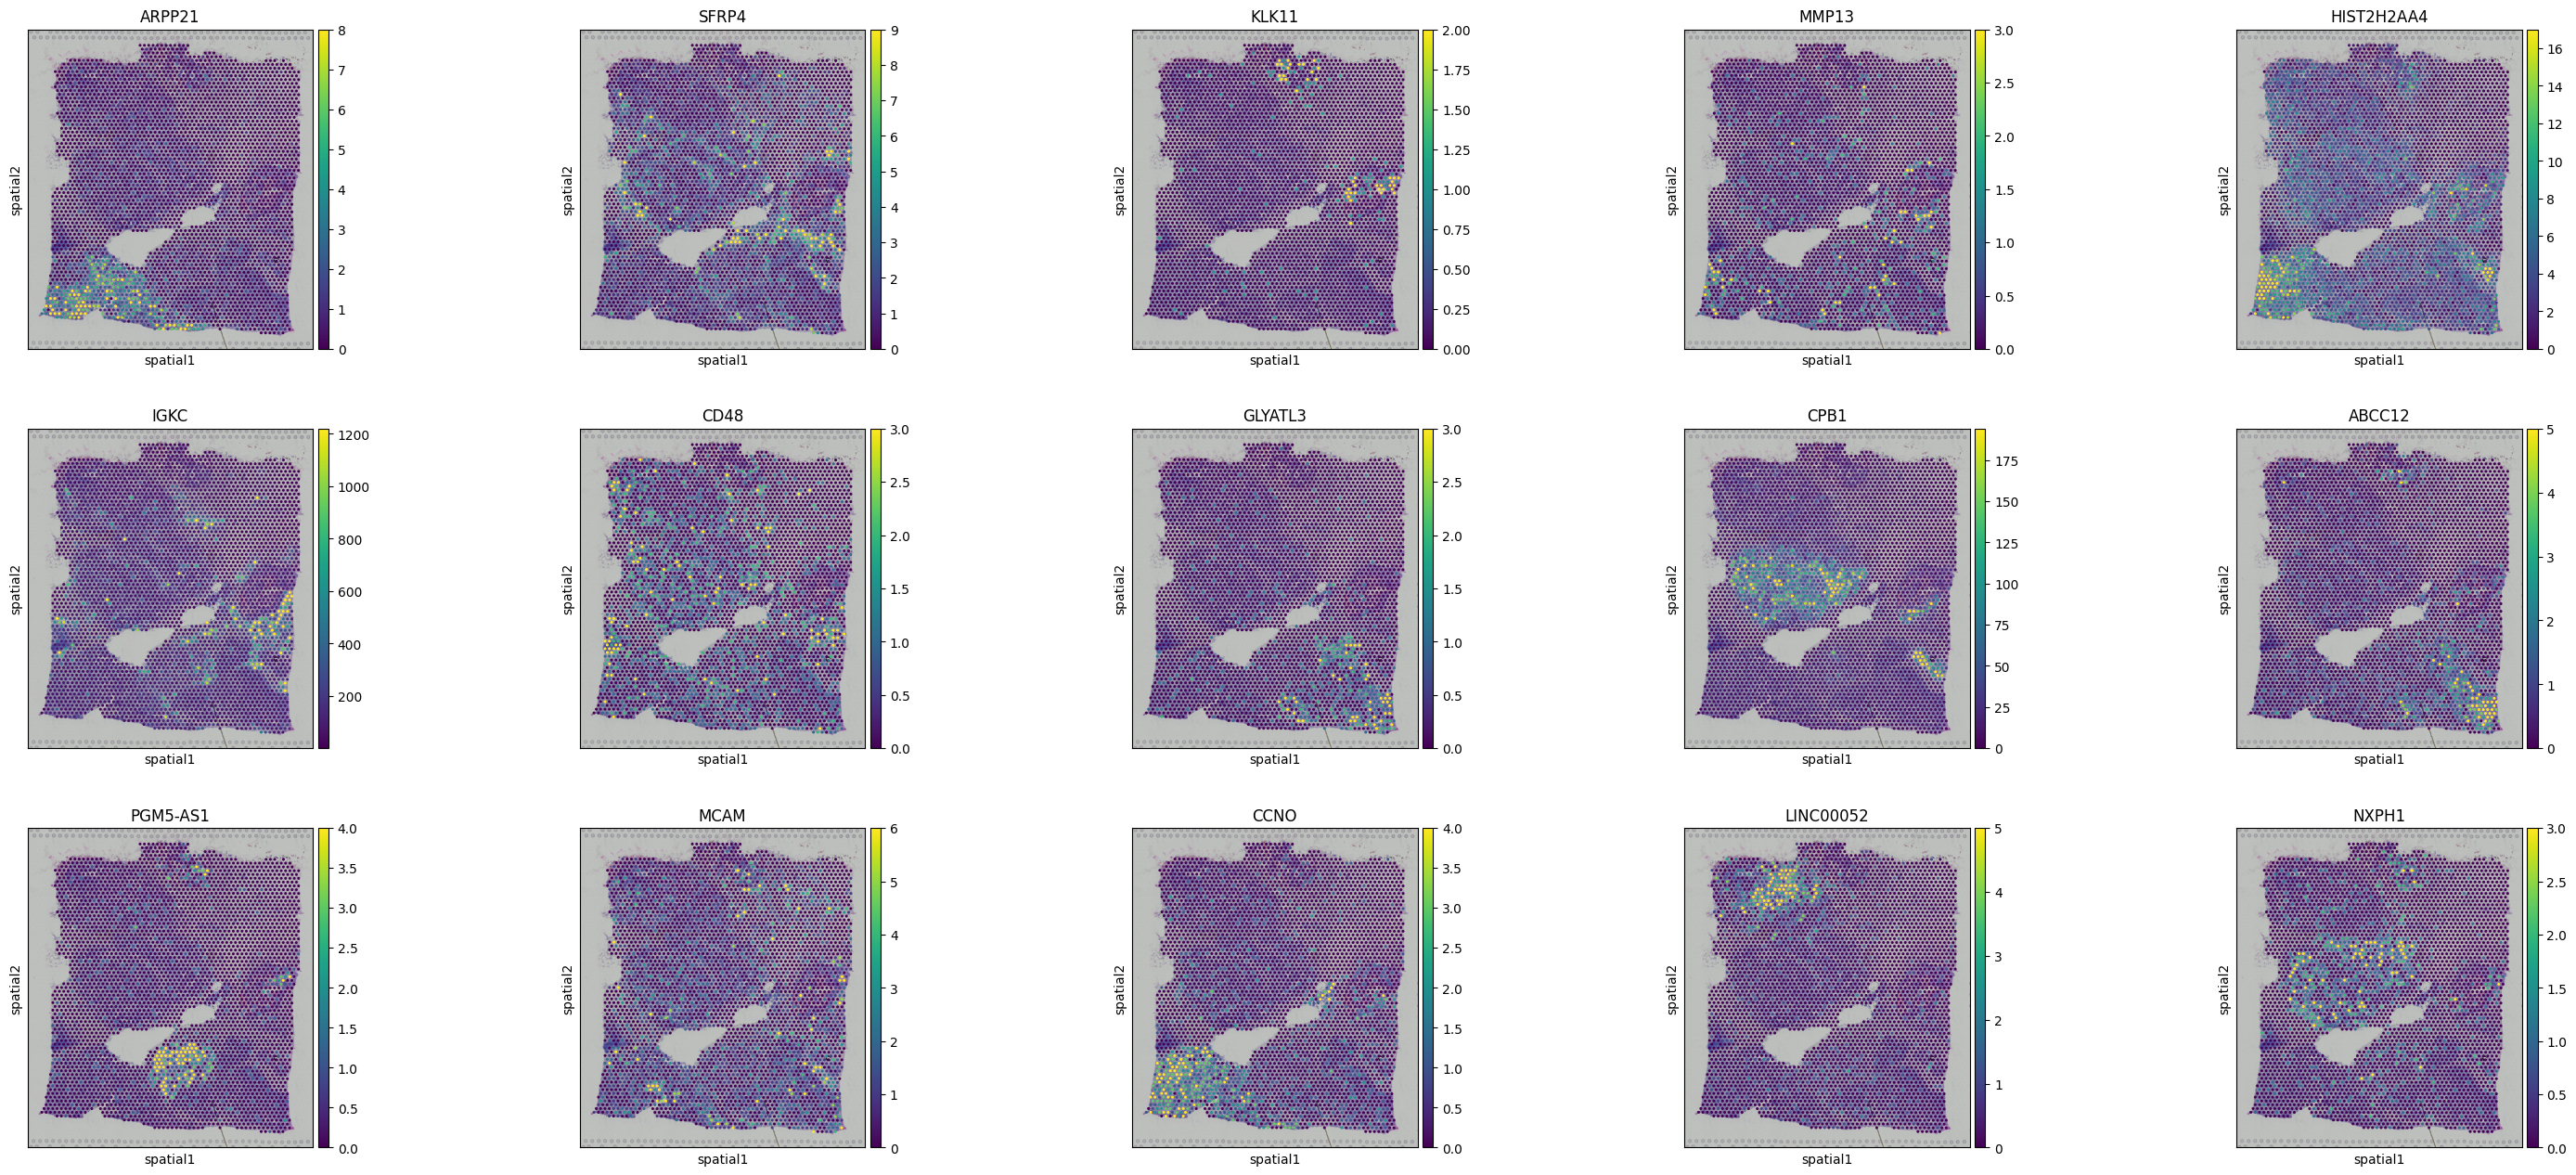

In [10]:
sc.pl.spatial(adata, color = top_genes, vmax = 'p99', ncols = 5)

Annotate with DISCOtoolkit_py (only for human)

We provide a convenice function to run discotoolkit_py

In [18]:
# Annotate with DISCOtoolkit_py
#!pip install discotoolkit
disco_results = sctm.analysis.get_topic_disco(beta)

INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend Sequentia